### Basic library imports

In [1]:
import os
import pandas as pd

### Read Dataset

In [2]:
DATASET_FOLDER = '../dataset/'
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))
sample_test = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test.csv'))
sample_test_out = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test_out.csv'))

In [3]:
# Count the number of unique group_id values
unique_group_ids = test['group_id'].nunique()

print(f'There are {unique_group_ids} unique group IDs in the dataset.')


There are 924 unique group IDs in the dataset.


459516    9458
752266    9063
281678    6137
308856    5437
731432    4741
          ... 
997333       2
656506       2
314298       2
178031       1
226428       1
Name: group_id, Length: 750, dtype: int64


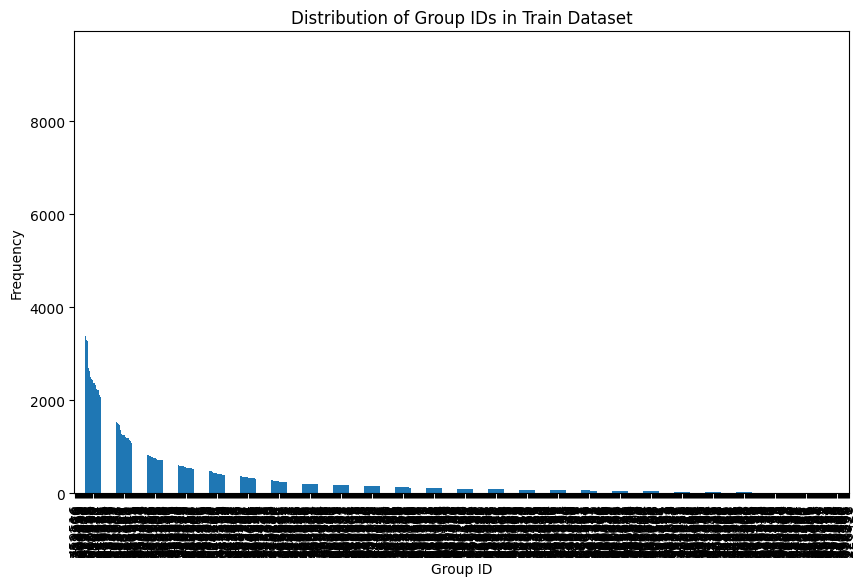

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Count occurrences of each group_id in the 'train' dataset
group_id_distribution = train['group_id'].value_counts()

# Display distribution
print(group_id_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
group_id_distribution.plot(kind='bar')
plt.title('Distribution of Group IDs in Train Dataset')
plt.xlabel('Group ID')
plt.ylabel('Frequency')
plt.show()


In [5]:
train

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram
...,...,...,...,...
263854,https://m.media-amazon.com/images/I/612J1R1xHl...,558806,height,5.0 centimetre
263855,https://m.media-amazon.com/images/I/61Blzh2+28...,470067,height,8.5 inch
263856,https://m.media-amazon.com/images/I/51MsegDL9V...,204245,height,43.2 centimetre
263857,https://m.media-amazon.com/images/I/510KhVw4VS...,752266,height,9.1 centimetre


752266    3099
478357    2513
810266    2067
483370    2058
866516    1814
          ... 
609802       1
728858       1
884378       1
177559       1
175150       1
Name: group_id, Length: 924, dtype: int64


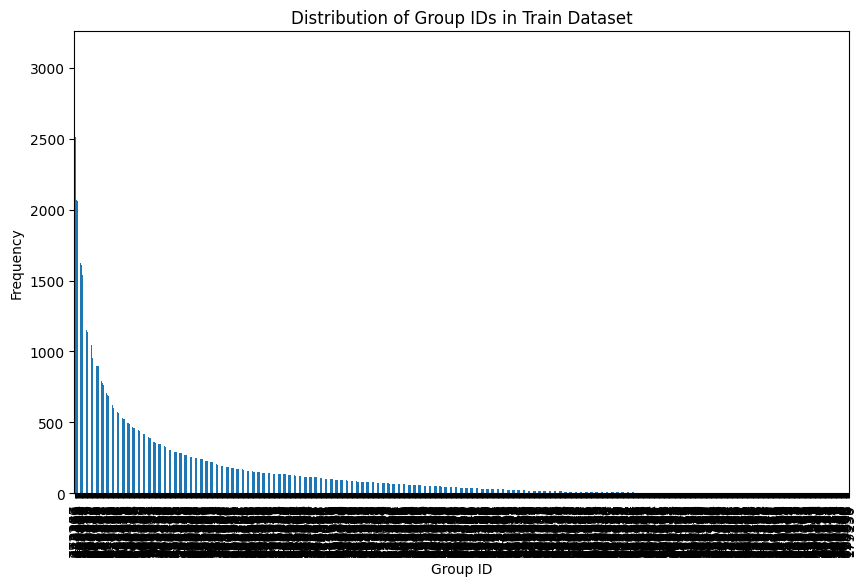

In [6]:
# Count occurrences of each group_id in the 'train' dataset
group_id_distribution = test['group_id'].value_counts()

# Display distribution
print(group_id_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
group_id_distribution.plot(kind='bar')
plt.title('Distribution of Group IDs in Train Dataset')
plt.xlabel('Group ID')
plt.ylabel('Frequency')
plt.show()

### Run Sanity check using src/sanity.py

In [7]:
!python sanity.py --test_filename ../dataset/sample_test.csv --output_filename ../dataset/sample_test_out.csv

Parsing successfull for file: ../dataset/sample_test_out.csv


In [8]:
!python sanity.py --test_filename ../dataset/sample_test.csv --output_filename ../dataset/sample_test_out_fail.csv

Error: Invalid unit [lbs] found in 6.75 lbs. Allowed units: {'metre', 'gram', 'microgram', 'fluid ounce', 'inch', 'millivolt', 'kilovolt', 'gallon', 'pint', 'cup', 'microlitre', 'pound', 'millilitre', 'volt', 'imperial gallon', 'quart', 'milligram', 'kilowatt', 'yard', 'decilitre', 'centimetre', 'millimetre', 'kilogram', 'cubic foot', 'litre', 'foot', 'cubic inch', 'centilitre', 'ton', 'watt', 'ounce'}


### Download images

In [9]:
# from utils import download_images
# download_images(train['image_link'], '../images')

In [ ]:
import os
import pytesseract
from PIL import Image
import pandas as pd
import torch
from transformers import AutoTokenizer, BertModel

# Set Tesseract command path
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

dataset_dir = "/raid/ai23resch11003/Adversarial/amazon-ml/images"
image_extensions = ['.png', '.jpg', '.jpeg']

output_dir = "/raid/ai23resch11003/Adversarial/amazon-ml/outputs"
output_filename = "output.csv"

os.makedirs(output_dir, exist_ok=True)

def extract_text_from_image(image_path):
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        return text
    except Exception as e:
        print(f"Error extracting text from {image_path}: {e}")
        return None

def apply_bert_to_text(text):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
    model = BertModel.from_pretrained('bert-base-cased')
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)  
    return embeddings

def process_dataset(dataset_dir):
    data = []  

    for filename in os.listdir(dataset_dir):
        if any(filename.lower().endswith(ext) for ext in image_extensions): 
            image_path = os.path.join(dataset_dir, filename)
            print(f"Processing {filename}...")

            text = extract_text_from_image(image_path)
            if text:
                print(f"Extracted Text from {filename}: {text[:100]}...")  

                embeddings = apply_bert_to_text(text)
                embeddings_flattened = embeddings.squeeze().tolist() 
                # Append the result as a dictionary
                data.append({
                    'image_name': filename,
                    'extracted_text': text,
                    'bert_embeddings': embeddings_flattened
                })

    return data

# Save data to CSV in the output directory
def save_to_csv(data, output_dir, output_filename):
    df = pd.DataFrame(data)
    
    csv_filepath = os.path.join(output_dir, output_filename)
    
    df.to_csv(csv_filepath, index=False)
    print(f"Data saved to {csv_filepath}")

data = process_dataset(dataset_dir)
save_to_csv(data, output_dir, output_filename)
